  # Genetski algoritam za p-median problem


  ## P-median problem
  
   P-median problem je NP-težak, diskretan optimizacioni problem čiji je cilj da od $n$ zadatih lokacija izabere $p$ lokacija ($p < n$) na koje će biti postavljeni resursi, koje će da koristi ostalih $n-p$ lokacija. Odabrane lokacije se nazivaju medijanama, a ostale klijentima (eng. demand points). Pritom, potrebno je minimizovati ukupnu sumu rastojanja izmedju svakog klijenta i njemu najbliže medijane.
  Kod p-median problema sa neograničenim kapacitetom podrazumeva se da svaki kandidat za medijanu može da opsluži neograničen broj klijenata. Kod p-median problema sa ograničenim kapacitetom kandidat za medijanu ima fiksiran kapacitet tj. dat je maksimalan broj klijenata koje može da opsluži. Ovde je prikazana varijanta sa neograničenim kapacitetom.
 <br>
  
  ### Matematički model problema
  
 <br>
 
 $min \sum_{i=1}^{n} \sum_{j=1}^{n} d_i{_j}x_i{_j}$  &emsp; &emsp; (1)   
 
 $\sum_{j=1}^{n}x_i{_j} = 1$, &emsp;  i=1,...,n  &emsp; &emsp; (2)
 
 $x_i{_j} \leq  y_j$, &emsp;  i,j=1,...,n  &emsp; &emsp; (3)
 
 $\sum_{j=1}^{n}y_j = p$  &emsp; &emsp; (4)
 
 $x_i{_j}, y_j \in \{0, 1\}$, &emsp;  i,j=1,...,n  &emsp; &emsp; (5)
 
 gde je:
 
 $n$ - ukupan broj lokacija
 
 $d_i{_j}$ - rastojanje lokacije $i$ od lokacije $j$ 
 
 $p$ - broj lokacija koje su odabrane za medijane
 
 $x_i{_j} = \left\{\begin{matrix}
 1, & \scriptsize ako & \scriptsize je & \scriptsize korisnik & \scriptsize na & \scriptsize lokaciji & \scriptsize i & \scriptsize dodeljen & \scriptsize resursu & \scriptsize na & \scriptsize lokaciji & \scriptsize j \\
 0, & \scriptsize inače
\end{matrix}\right.$

 $y_j = \left\{\begin{matrix}
 1, & \scriptsize ako & \scriptsize je & \scriptsize lokacija & \scriptsize j & \scriptsize uzeta & \scriptsize kao & \scriptsize medijana \\
 0, & \scriptsize inače
\end{matrix}\right.$

<br>
Funkcija cilja (1) minimizuje ukupnu sumu rastojanja izmedju klijenata i skupa medijana. Oraničenjem (2) garantuje da je svaki klijent dodeljen tačno jednoj medijani. Ograničenje (3) zabranjuje da klijent bude dodeljen lokaciji koja nije izabrana za medijanu. Ograničenje (4) garantuje da je izabrano $p$ lokacija koje će biti medijane, a ograničenje (5) da su $x$ i $y$ binarne vrednosti.

## Rešavanje p-median problema pomoću genetskog algoritma


### Reprezentacija jedinki

Svaka jedinka (hromozom) se sastoji od $p$ gena, a svaki gen predstavlja indeks lokacije koja je izabrana za medijanu. Na primer, ako imamo 15 lokacija označenih indeksima 1,2,...,15 i želimo da izaberemo 5 medijana, hromozom oblika \[ 2,7,5,15,10\] će biti jedan kandidat za rešenje i podrazumevaće da su lokacije 2,5,7,10 i 15 odabrane za medijane.

### Fitnes funkcija

Funkcija prilagođenosti jednog hromozoma je predstavljena jednačinom (1) iz matematičkog modela problema. Da bi se izračunala prilagođenost datog hromozoma, potrebno je prvo sve ostale lokacije dodeliti njima najbližim medijanama iz tog hromozoma.

### Selekcija

Selekcija jedinki koje će služiti za generisanje nove generacije je rangovski bazirana, što znači da će bolja rešenja biti češće birana. Neka je $R$ lista hromozoma rangiranih u rastućem poretku na osnovu vrednosti fitnes funkcije, $L$ broj hromozoma, a $rnd$ random broj između 0 i 1. Tada se narednom jednačinom računa indeks ($j$) jedinke koja će biti izabrana iz liste $R$:

$\text { Select }(R)=\left\{r_{j} \in R | j=L- \lfloor \frac{-1+\sqrt{1+4 r n d\left(L^{2}+L\right)}}{2} \rfloor \right\}$


### Crossover

Ukrštanje dva hromozoma se vrši na sledeći način:
Prvo se za oba roditelja izračunaju vektori za razmenu (eng. exchange vectors). Vektor za razmenu roditelja1 sadrži gene (tj. indekse lokacija) koji su prisutni u roditelju1, a nisu u roditelju2. To omogućuje bezbedan transfer tih gena u roditelja2 i obezbeđuje da se nakon ukrštanja u roditelju2 ne pojave duplirani geni. Slično se formira i vektor za razmenu roditelja2. Na primer, ako su roditelji p1 = [1, 2, 3, 4, 5] i p2 = [2, 5, 9, 10, 12], onda će njihovi vektori za razmenu biti vp1 = [1, 3, 4] i vp2 = [9, 10, 12].

Ukrštanje se primenjuje svaki put kad dva roditelja nisu jednaka, tj. kad se u vektorima za razmenu oba roditelja nalazi bar jedan element. Ako su roditelji jednaki, jedan od njih se neizmenjen prenosi u narednu generaciju, a drugi se izbacuje, kako bi se izbeglo dodavanje dupliranih jedinki u populaciju.

Potrebno je generisati random prirodan broj $c$ u granicama od 1 do broja elemenata u kojima se roditelji razlikuju (tj. do dužine vektora za razmenu minus 1). Taj broj $c$ određuje koliko elemenata iz vektora za razmenu će biti razmenjeno između dva roditelja.  


### Mutacija

Operator mutacije se primenjuje sa određenom verovatnoćom $mutation$ $prob$. Za svaku jedinku se generiše random broj. Ako je on manji od vrednosti $mutation$ $prob$, mutacija će se izršiti. 
Mutacija podrazumeva da će random izabrana medijana iz datog hromozoma biti zamenjena random izabranim klijenotm.

### Formiranje inicijalne populacije

Ovde je inicijalna populacija formirana na dva načina:

1) Random izborom: svaki gen svake jedinke je nasumično izabran iz skupa dostupnih lokacija

2) Random izborom uz ažuriranje:

        Za svaku jedinku:
            Random izabrati p-medijane;
            Ostale lokacije (klijente) dodeliti njima najbližim medijanama 
            (Time se formiraju klasteri lokacija);
            Za svaku medijanu:
                Odrediti centralnu lokaciju koja ima najmanje rastojanje do svih klijenata 
                koji su dodeljeni toj medijani;
                Zameniti medijanu tom centralnom lokacijom;
        Vratiti tako formiranu populaciju;
                
                
### Hipermutacija

Ovaj operator se primenjuje odmah nakon generisanja random inicijalne populacije, a nakon toga se u svakoj iteraciji (posle ukrštanja i mutacije) primenjuje sa fiksiranom verovatnoćom (npr. oko 0.5%). Radi na sledeći način:

Na slučajan način bira određeni procenat (npr. 10%) populacije, a zatim pokušava da popravi fitnes svake od izabranih jedinki. Svaki gen jedinke pokušava da zameni svakom od lokacija koje nisu trenutno prisutne u genotipu te jedinke. Zadržava se ona zamena koja najviše popravlja vrednost fitnes funkcije. 

Ovo je veoma računski zahtevan operator pošto se pri svakoj njegovoj primeni računa veliki broj fitnes funkcija.

In [8]:
!unzip OR-Library.zip

Archive:  OR-Library.zip
   creating: OR-Library/
  inflating: OR-Library/pmed9.txt    
  inflating: OR-Library/pmed8.txt    
  inflating: OR-Library/pmed7.txt    
  inflating: OR-Library/pmed6.txt    
  inflating: OR-Library/pmed5.txt    
  inflating: OR-Library/pmed4.txt    
  inflating: OR-Library/pmed3.txt    
  inflating: OR-Library/pmed2.txt    
  inflating: OR-Library/pmed15.txt   
  inflating: OR-Library/pmed14.txt   
  inflating: OR-Library/pmed13.txt   
  inflating: OR-Library/pmed12.txt   
  inflating: OR-Library/pmed11.txt   
  inflating: OR-Library/pmed10.txt   
  inflating: OR-Library/pmed1.txt    


In [9]:
!unzip Lorena\ dataset.zip

Archive:  Lorena dataset.zip
   creating: Lorena dataset/
  inflating: Lorena dataset/pmedian818.txt  
  inflating: Lorena dataset/pmedian3282.txt  
  inflating: Lorena dataset/pmedian324.txt  


In [1]:
import random, string
import sys, os
import copy
import numpy as np
import time
from matplotlib import pyplot as plt
from IPython import display

In [3]:
def read_ORLibrary_input_file(file_path):
    """ 
    Reads data from OR-Library file and creates cost matrix.
    http://people.brunel.ac.uk/~mastjjb/jeb/orlib/pmedinfo.html

    The format of these data files is:
    First line: number of vertices, number of edges, p
    Other lines: the end vertices and the cost of the edge
    """
    
    try:
        with open(file_path, "r") as f:
            first_line = f.readline().strip().split(' ')
            num_vertices = int(first_line[0])
            num_edges = int(first_line[1])
            p = int(first_line[2])
            
            cost_matrix = np.matrix(np.ones((num_vertices, num_vertices)) * np.inf)
            
            for line in f:
                line = line.strip().split(' ')  
                cost_matrix[int(line[0])-1, int(line[1])-1] = int(line[2])
                cost_matrix[int(line[1])-1, int(line[0])-1] = int(line[2])
        
            for i in range(0, num_vertices):
                cost_matrix[i, i] = 0
               
            # Floyd–Warshall algorithm for shortest path
            # https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm
            for k in range(0, num_vertices):
                for i in range(0, num_vertices):
                    for j in range(0, num_vertices):
                        if cost_matrix[i,j] > cost_matrix[i,k] + cost_matrix[k,j]: 
                            cost_matrix[i,j] = cost_matrix[i,k] + cost_matrix[k,j]
                        
        
            return num_vertices, p, cost_matrix
        
    except IOError:
        return None
    

In [4]:
def euclidean_distance(x1, x2, y1, y2):
  return int(np.sqrt((x1-x2)**2) + (y1-y2)**2)


def read_Lorena_input_file(file_path):
    """
    Reads data from Lorena file and creates cost matrix.
    http://www.lac.inpe.br/~lorena/instancias.html

    The format of these data files is:
    First line: number of vertices, p
    Other lines: X Y  co-ordinates of points. 
    """

    try:
        with open(file_path, "r") as f:
            first_line = f.readline().strip().split(' ')
            num_vertices = int(first_line[0])
            p = int(first_line[1])
            
            cost_matrix = np.matrix(np.ones((num_vertices, num_vertices)) * np.inf)
            points = np.empty(shape=(num_vertices, 2))

            i = 0
            for line in f:
                line = line.strip().split(' ')
                points[i, 0] = int(line[0])
                points[i, 1] = int(line[1])
                i +=1 

            for i in range(num_vertices):
              for j in range(i, num_vertices):
                if i != j:
                  cost_matrix[i,j] = euclidean_distance(points[i,0], points[j,0], points[i,1], points[j,1])
                else:
                  cost_matrix[i,j] = 0
                cost_matrix[j,i] = cost_matrix[i,j]

            return num_vertices, p, cost_matrix

    except IOError:
        return None
    

In [5]:
class Chromosome:
    
    """
    Class Chromosome represents one chromosome which consists of genetic code and value of 
    fitness function.
    Genetic code represents potential solution to problem - the list of locations that are selected
    as medians.
    """
    
    def __init__(self, content, fitness):
        self.content = content
        self.fitness = fitness
    def __str__(self): return "%s f=%d" % (self.content, self.fitness)
    def __repr__(self): return "%s f=%d" % (self.content, self.fitness)
    

In [6]:
class GeneticAlgorithm:
   
    def __init__(self,num_facilities, p, cost_matrix, init_population_with_center_point=False, apply_hypermutation=False):
        
        self.num_facilities = num_facilities
        self.p = p
        self.cost_matrix = cost_matrix
        
        self.init_population_with_center_point = init_population_with_center_point
        self.apply_hypermutation = apply_hypermutation
    
        self.iterations = 50                                      # Maximal number of iterations
        self.current_iteration = 0
        self.generation_size = 35                                 # Number of individuals in one generation
        self.reproduction_size = 13                               # Number of individuals for reproduction
        
        self.mutation_prob = 0.3                                  # Mutation probability
        self.hypermutation_prob = 0.03                            # Hypermutation probability
        self.hypermutation_population_percent = 10

        self.top_chromosome = None      # Chromosome that represents solution of optimization process
        
        
    def mutation(self, chromosome):
        """ 
        Applies mutation over chromosome with probability self.mutation_prob
        In this process, a randomly selected median is replaced with a randomly selected demand point.
        """

        mp = random.random()
        if mp < self.mutation_prob:
            # index of randomly selected median:
            i = random.randint(0, len(chromosome)-1)
            # demand points without current medians:
            demand_points = [element for element in range(0,len(self.cost_matrix)) if element not in chromosome] 
            # replace selected median with randomly selected demand point:
            chromosome[i] = random.choice(demand_points)
            
        return chromosome
    
    
    def crossover(self, parent1, parent2):
        
        identical_elements = [element for element in parent1 if element in parent2]
        
        # If the two parents are equal to each other, one of the parents is reproduced unaltered for the next generation 
        # and the other parent is deleted, to avoid that duplicate individuals be inserted into the population.
        if len(identical_elements) == len(parent1):
            return parent1, None
      
        child1 = []
        child2 = []

        exchange_vector_for_parent1 = [element for element in parent1 if element not in identical_elements]
        exchange_vector_for_parent2 = [element for element in parent2 if element not in identical_elements]   
        
        c = random.randint(0, len(exchange_vector_for_parent1)-1)
        
        for i in range(c):
            exchange_vector_for_parent1[i], exchange_vector_for_parent2[i] = exchange_vector_for_parent2[i], exchange_vector_for_parent1[i]

        child1 = identical_elements + exchange_vector_for_parent1
        child2 = identical_elements + exchange_vector_for_parent2
        
        return child1, child2


    def cost_to_nearest_median(self, facility, medians): 
        """ For given facility, returns cost to its nearest median """
        min_cost = self.cost_matrix[facility, medians[0]]
        for median in medians:
            if min_cost > self.cost_matrix[facility, median]:
                min_cost = self.cost_matrix[facility, median]
        return min_cost

    def fitness(self, chromosome):
        """ Calculates fitness of given chromosome """
        cost_sum = 0
        for i in range(self.num_facilities):
            cost_sum += self.cost_to_nearest_median(i, chromosome)
        return cost_sum
    
    
    def initial_random_population(self):
        """ 
        Creates initial population by generating self.generation_size random individuals.
        Each individual is created by randomly choosing p facilities to be medians.
        """

        init_population = []
        for k in range(self.generation_size):
            rand_medians = []
            facilities = list(range(self.num_facilities))
            for i in range(self.p):
                rand_median = random.choice(facilities)
                rand_medians.append(rand_median)
                facilities.remove(rand_median)
            init_population.append(rand_medians)

        init_population = [Chromosome(content, self.fitness(content)) for content in init_population]
        self.top_chromosome = min(init_population, key=lambda chromo: chromo.fitness)
        print("Current top solution: %s" % self.top_chromosome)
        return init_population
    
    
    def selection(self, chromosomes):
        """Ranking-based selection method"""

        # Chromosomes are sorted ascending by their fitness value  
        chromosomes.sort(key=lambda x: x.fitness)
        L = self.reproduction_size
        selected_chromosomes = []
        
        for i in range(self.reproduction_size):
            j = L - np.floor((-1 + np.sqrt(1 + 4*random.uniform(0, 1)*(L**2 + L))) / 2)
            selected_chromosomes.append(chromosomes[int(j)])
        return selected_chromosomes
    
    
    def create_generation(self, for_reproduction):
        """
        Creates new generation from individuals that are chosen for reproduction, 
        by applying crossover and mutation operators. 
        Size of the new generation is same as the size of previous. 
        """
        new_generation = []
       
        while len(new_generation) < self.generation_size:
            parents = random.sample(for_reproduction, 2)
            child1, child2 = self.crossover(parents[0].content, parents[1].content)

            self.mutation(child1)
            new_generation.append(Chromosome(child1, self.fitness(child1)))
            
            if child2 != None and len(new_generation) < self.generation_size:
                self.mutation(child2)
                new_generation.append(Chromosome(child2, self.fitness(child2)))
            
        return new_generation
    
    
    def nearest_median(self, facility, medians):
        """ Returns the nearest median for given facility """
        min_cost = self.cost_matrix[facility, medians[0]]
        nearest_med = medians[0]
        for median in medians:
            if min_cost > self.cost_matrix[facility, median]:
                nearest_med = median        
        return nearest_med
    
    
    def initial_population_with_center_point(self):
        """
        Creates initial population.
        Based on paper: Oksuz, Satoglu, Kayakutlu: 'A Genetic Algorithm for the P-Median Facility Location Problem'
        """
        
        init_population = []
        for k in range(self.generation_size):
            
            # Randomly select p-medians
            medians = []
            facilities = list(range(self.num_facilities))
            for i in range(self.p):
                rand_median = random.choice(facilities)
                medians.append(rand_median)
                facilities.remove(rand_median)
                
            # Assign all demand points to nearest median
            median_nearestpoints_map = dict((el, []) for el in medians)
            for i in range(self.num_facilities):
                median_nearestpoints_map[self.nearest_median(i, medians)].append(i)
                
            n = len(medians)
            # For each median
            for i in range(n):
                median = medians[i]
                # Determine the center point which has minimum distance to all demand points 
                # that assigned this median
                min_dist = float(np.inf)
                center_point = median
                
                cluster = [median] + median_nearestpoints_map[median]
                for point in cluster:
                    dist = 0
                    for other_point in cluster:
                        dist += self.cost_matrix[point, other_point]
                    if dist < min_dist:
                        min_dist = dist
                        center_point = point
                                        
                # Replace the median with center point
                medians[i] = center_point
            
            init_population.append(medians)

        init_population = [Chromosome(content, self.fitness(content)) for content in init_population]
        self.top_chromosome = min(init_population, key=lambda chromo: chromo.fitness)
        print("Current top solution: %s" % self.top_chromosome)
        return init_population

    
    
    def optimize(self):
        
        start_time = time.time()
        
        if self.init_population_with_center_point:
            chromosomes = self.initial_population_with_center_point()
        else:
            chromosomes = self.initial_random_population()
  
        while self.current_iteration < self.iterations:
            print("Iteration: %d" % self.current_iteration)

            # From current population choose individuals for reproduction
            for_reproduction = self.selection(chromosomes)

            # Create new generation from individuals that are chosen for reproduction 
            chromosomes = self.create_generation(for_reproduction)
            
            if self.apply_hypermutation:
                hp = random.random()
                if hp < self.hypermutation_prob:
                    print("Hypermutation...")

                    chromosomes_content = [chromo.content for chromo in chromosomes]

                    # choose individuals on which hypermutation will be applied
                    k = int(self.generation_size * self.hypermutation_population_percent / 100)
                    individuals_subset = random.sample(chromosomes_content, k)
                    
                    for individual in individuals_subset:
                        chromosomes_content.remove(individual)
                    
                    new_individuals_subset = self.hypermutation(individuals_subset)
                    
                    for individual in new_individuals_subset:
                        chromosomes_content.append(individual)
                    
                    chromosomes = [Chromosome(chromo_content, self.fitness(chromo_content)) for chromo_content in chromosomes_content]
                
            
            self.current_iteration += 1
            
            chromosome_with_min_fitness = min(chromosomes, key=lambda chromo: chromo.fitness)
            if chromosome_with_min_fitness.fitness < self.top_chromosome.fitness:
                self.top_chromosome = chromosome_with_min_fitness
            print("Current top solution: %s" % self.top_chromosome)
            print()
            
        end_time = time.time()
        self.time = end_time - start_time
        hours, rem = divmod(end_time - start_time, 3600)
        minutes, seconds = divmod(rem, 60)
            
        print()
        print("Final top solution: %s" % self.top_chromosome)
        print('Time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))
    
    
    
    def hypermutation(self, individuals_subset):
        
        n = len(individuals_subset)

        # FOR EACH individual X from selected individuals DO
        for idx in range(n):
            X = individuals_subset[idx]
            
            # Let H be the set of facility indexes that are not currently present 
            # in the genotype of individual X
            H = [element for element in range(self.num_facilities) if element not in X]

            # FOR EACH facility index “i” included in set H DO
            for i in H:

                best = X

                # FOR EACH facility index “j” that is currently present in the genotype of 
                # the individual X DO
                for j in X:

                    # Let Y be a new individual with the set of facilities given by: (X – {j}) ∪ {i}
                    Y = copy.deepcopy(X)
                    Y.remove(j)
                    Y = Y + [i]

                    if self.fitness(Y) < self.fitness(best):
                        best = Y
                        
                if self.fitness(best) < self.fitness(X):
                    # Insert the new X into the population, replacing the old X
                    individuals_subset[idx] = best
        
        return individuals_subset


    def medians_and_assigned_demand_points(self):
      median_nearestpoints_map = dict((median, []) for median in self.top_chromosome.content)
      for i in range(self.num_facilities):
        median_nearestpoints_map[self.nearest_median(i, self.top_chromosome.content)].append(i)
      return median_nearestpoints_map

    

### Lorena instance - pmedian324 

In [ ]:
num_vertices, p, cost_matrix = read_Lorena_input_file('Lorena dataset/pmedian324.txt')

In [ ]:
cost_matrix

matrix([[      0.,   24028.,   11787., ...,  794643.,  612108.,  548246.],
        [  24028.,       0.,   69295., ..., 1094875.,  878550.,  801668.],
        [  11787.,   69295.,       0., ...,  613974.,  454983.,  400193.],
        ...,
        [ 794643., 1094875.,  613974., ...,       0.,   12059.,   22917.],
        [ 612108.,  878550.,  454983., ...,   12059.,       0.,    1826.],
        [ 548246.,  801668.,  400193., ...,   22917.,    1826.,       0.]])

In [ ]:
# Initial population with determining the center point of cluster  
genetic = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=True, apply_hypermutation=False)
genetic.optimize()

Current top solution: [274, 263, 323, 92, 203] f=7448613
Iteration: 0
Current top solution: [153, 170, 79, 56, 301] f=5859828

Iteration: 1
Current top solution: [153, 170, 79, 56, 301] f=5859828

Iteration: 2
Current top solution: [153, 170, 79, 56, 301] f=5859828

Iteration: 3
Current top solution: [153, 170, 79, 56, 301] f=5859828

Iteration: 4
Current top solution: [153, 170, 79, 56, 301] f=5859828

Iteration: 5
Current top solution: [153, 170, 79, 56, 301] f=5859828

Iteration: 6
Current top solution: [153, 170, 79, 56, 301] f=5859828

Iteration: 7
Current top solution: [153, 170, 79, 56, 301] f=5859828

Iteration: 8
Current top solution: [153, 170, 79, 56, 301] f=5859828

Iteration: 9
Current top solution: [138, 198, 13, 206, 292] f=5722452

Iteration: 10
Current top solution: [138, 198, 13, 206, 292] f=5722452

Iteration: 11
Current top solution: [138, 198, 13, 206, 292] f=5722452

Iteration: 12
Current top solution: [138, 198, 13, 206, 292] f=5722452

Iteration: 13
Current top 

In [ ]:
# Random initial population
genetic2 = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=False, apply_hypermutation=False)
genetic2.optimize()

Current top solution: [84, 152, 223, 289, 33] f=9527288
Iteration: 0
Current top solution: [45, 319, 260, 129, 263] f=6924137

Iteration: 1
Current top solution: [45, 319, 260, 129, 263] f=6924137

Iteration: 2
Current top solution: [213, 260, 18, 120, 296] f=6770414

Iteration: 3
Current top solution: [213, 260, 18, 120, 296] f=6770414

Iteration: 4
Current top solution: [315, 260, 18, 98, 213] f=6727297

Iteration: 5
Current top solution: [212, 18, 63, 307, 98] f=6517746

Iteration: 6
Current top solution: [211, 18, 63, 307, 98] f=6251797

Iteration: 7
Current top solution: [206, 18, 63, 120, 252] f=6199186

Iteration: 8
Current top solution: [206, 18, 63, 120, 252] f=6199186

Iteration: 9
Current top solution: [206, 18, 63, 120, 252] f=6199186

Iteration: 10
Current top solution: [206, 18, 63, 120, 252] f=6199186

Iteration: 11
Current top solution: [206, 18, 63, 120, 252] f=6199186

Iteration: 12
Current top solution: [206, 18, 63, 120, 252] f=6199186

Iteration: 13
Current top sol

In [ ]:
print(genetic2.medians_and_assigned_demand_points())

{143: [9, 18, 38, 74, 82, 83, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 256, 257, 258, 267, 268, 276, 284, 319], 167: [], 241: [], 279: [7, 8, 16, 17, 27, 28, 29, 37, 73, 79, 81, 84, 85, 89, 248, 254, 255, 265, 266, 274, 275, 282, 283, 290, 291, 292, 297, 298, 304, 309], 21: [0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23, 24, 25, 26, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 75, 76, 77, 78, 80, 86, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 19

In [ ]:
# Hypermutation + random initial population
genetic3 = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=False, apply_hypermutation=True)
genetic3.optimize()

Current top solution: [132, 245, 290, 292, 169] f=9082428
Iteration: 0
Current top solution: [116, 58, 239, 275, 314] f=7033730

Iteration: 1
Current top solution: [116, 58, 239, 275, 314] f=7033730

Iteration: 2
Current top solution: [106, 239, 314, 275, 219] f=5876210

Iteration: 3
Current top solution: [106, 239, 314, 275, 219] f=5876210

Iteration: 4
Current top solution: [106, 239, 314, 275, 219] f=5876210

Iteration: 5
Current top solution: [106, 239, 314, 275, 219] f=5876210

Iteration: 6
Current top solution: [106, 239, 314, 275, 219] f=5876210

Iteration: 7
Current top solution: [106, 239, 314, 275, 219] f=5876210

Iteration: 8
Current top solution: [106, 239, 314, 275, 219] f=5876210

Iteration: 9
Current top solution: [314, 138, 274, 30, 60] f=5857703

Iteration: 10
Current top solution: [314, 138, 274, 30, 60] f=5857703

Iteration: 11
Current top solution: [314, 138, 274, 30, 60] f=5857703

Iteration: 12
Current top solution: [314, 138, 274, 30, 60] f=5857703

Iteration: 13

In [ ]:
print(genetic3.medians_and_assigned_demand_points())

{20: [2, 10, 19, 20, 21, 30, 31, 52, 54, 55, 56, 57, 58, 59, 61, 62, 65, 66, 167, 171, 172, 173, 174, 179, 180, 185, 186, 188, 192, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 214, 215, 217, 218, 219, 220, 223, 224, 225, 233, 237, 238, 244, 245, 249, 259, 269, 285, 305], 8: [], 311: [0, 1, 3, 4, 5, 11, 12, 13, 14, 22, 23, 24, 25, 26, 32, 33, 34, 35, 36, 39, 40, 68, 69, 70, 71, 75, 76, 77, 80, 86, 243, 246, 247, 250, 251, 252, 253, 260, 261, 262, 263, 264, 270, 271, 272, 277, 278, 279, 280, 286, 287, 288, 289, 293, 294, 295, 299, 300, 301, 302, 303, 306, 307, 308, 310, 311, 312, 313, 314, 315, 316, 317, 318], 198: [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 60, 63, 64, 67, 164, 165, 166, 168, 169, 170, 175, 176, 177, 178, 181, 182, 183, 184, 187, 189, 190, 191, 193, 194, 195, 196, 197, 198, 209, 213, 216, 221, 222, 226, 227, 228, 229, 230, 231, 232, 234, 235, 236, 239, 240, 241, 242, 320, 321, 322, 323], 138: [6, 7, 8, 9, 15, 16, 17, 18, 27, 28, 29, 37, 38, 72,

In [ ]:
# Hypermutation + Initial population with determining the center point of cluster
genetic4 = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=True, apply_hypermutation=True)
genetic4.optimize()

Current top solution: [97, 301, 85, 229, 212] f=5889052
Iteration: 0
Current top solution: [97, 301, 85, 229, 212] f=5889052

Iteration: 1
Current top solution: [97, 301, 85, 229, 212] f=5889052

Iteration: 2
Current top solution: [97, 301, 85, 229, 212] f=5889052

Iteration: 3
Current top solution: [97, 301, 85, 229, 212] f=5889052

Iteration: 4
Current top solution: [97, 301, 85, 229, 212] f=5889052

Iteration: 5
Current top solution: [97, 301, 85, 229, 212] f=5889052

Iteration: 6
Current top solution: [97, 301, 85, 229, 212] f=5889052

Iteration: 7
Current top solution: [97, 301, 85, 229, 212] f=5889052

Iteration: 8
Current top solution: [97, 301, 85, 229, 212] f=5889052

Iteration: 9
Current top solution: [97, 301, 85, 229, 212] f=5889052

Iteration: 10
Current top solution: [97, 301, 85, 229, 212] f=5889052

Iteration: 11
Current top solution: [97, 301, 85, 229, 212] f=5889052

Iteration: 12
Current top solution: [97, 301, 85, 229, 212] f=5889052

Iteration: 13
Current top solut

### Lorena instance - pmedian818

In [11]:
num_vertices, p, cost_matrix = read_Lorena_input_file('Lorena dataset/pmedian818.txt')

In [ ]:
# Initial population with determining the center point of cluster
genetic = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=True, apply_hypermutation=False)
genetic.optimize()

Current top solution: [359, 484, 129, 709, 599] f=57205446
Iteration: 0
Current top solution: [359, 484, 129, 709, 599] f=57205446

Iteration: 1
Current top solution: [359, 484, 129, 709, 599] f=57205446

Iteration: 2
Current top solution: [344, 690, 560, 702, 239] f=54703801

Iteration: 3
Current top solution: [344, 690, 180, 255, 702] f=53126358

Iteration: 4
Current top solution: [344, 690, 64, 660, 14] f=52347489

Iteration: 5
Current top solution: [112, 690, 180, 708, 14] f=47645990

Iteration: 6
Current top solution: [112, 690, 180, 708, 14] f=47645990

Iteration: 7
Current top solution: [112, 690, 180, 708, 14] f=47645990

Iteration: 8
Current top solution: [112, 690, 180, 708, 14] f=47645990

Iteration: 9
Current top solution: [105, 690, 758, 20, 660] f=45993335

Iteration: 10
Current top solution: [292, 690, 758, 803, 660] f=45449439

Iteration: 11
Current top solution: [292, 690, 758, 803, 660] f=45449439

Iteration: 12
Current top solution: [292, 690, 758, 803, 660] f=454494

In [14]:
# Hypermutation + Initial population with determining the center point of cluster
genetic = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=True, apply_hypermutation=True)
genetic.optimize()

Current top solution: [121, 698, 197, 363, 230] f=59555317
Iteration: 0
Current top solution: [478, 587, 311, 104, 660] f=53629739

Iteration: 1
Current top solution: [478, 587, 311, 104, 660] f=53629739

Iteration: 2
Current top solution: [478, 587, 311, 104, 660] f=53629739

Iteration: 3
Current top solution: [504, 104, 611, 187, 338] f=53086310

Iteration: 4
Current top solution: [504, 104, 611, 187, 338] f=53086310

Iteration: 5
Current top solution: [504, 104, 611, 187, 338] f=53086310

Iteration: 6
Current top solution: [504, 104, 611, 187, 338] f=53086310

Iteration: 7
Current top solution: [108, 655, 504, 31, 375] f=52957638

Iteration: 8
Current top solution: [108, 655, 504, 31, 375] f=52957638

Iteration: 9
Hypermutation...
Current top solution: [108, 655, 504, 31, 375] f=52957638

Iteration: 10
Current top solution: [108, 655, 504, 31, 375] f=52957638

Iteration: 11
Current top solution: [108, 655, 504, 31, 375] f=52957638

Iteration: 12
Current top solution: [430, 504, 375,

### OR-Library instance - pmed3

In [ ]:
num_vertices, p, cost_matrix = read_ORLibrary_input_file('OR-Library/pmed3.txt')

In [ ]:
cost_matrix

matrix([[  0.,  77., 139., ..., 114., 105.,  66.],
        [ 77.,   0.,  62., ..., 191., 182., 143.],
        [139.,  62.,   0., ..., 206., 209., 205.],
        ...,
        [114., 191., 206., ...,   0.,   9.,  48.],
        [105., 182., 209., ...,   9.,   0.,  39.],
        [ 66., 143., 205., ...,  48.,  39.,   0.]])

In [ ]:
# Initial population with determining the center point of cluster
genetic = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=True, apply_hypermutation=False)
genetic.optimize()

Current top solution: [76, 66, 83, 98, 59, 35, 94, 74, 32, 14] f=5074
Iteration: 0
Current top solution: [76, 66, 83, 98, 59, 35, 94, 74, 32, 14] f=5074

Iteration: 1
Current top solution: [13, 35, 76, 51, 18, 98, 99, 68, 25, 11] f=4909

Iteration: 2
Current top solution: [76, 35, 13, 20, 24, 71, 53, 98, 68, 46] f=4741

Iteration: 3
Current top solution: [99, 76, 35, 13, 28, 98, 68, 25, 19, 46] f=4680

Iteration: 4
Current top solution: [99, 76, 35, 13, 28, 98, 68, 25, 19, 46] f=4680

Iteration: 5
Current top solution: [99, 76, 35, 13, 28, 98, 68, 25, 19, 46] f=4680

Iteration: 6
Current top solution: [99, 76, 35, 13, 28, 98, 68, 25, 19, 46] f=4680

Iteration: 7
Current top solution: [76, 25, 35, 98, 19, 13, 99, 68, 39, 20] f=4677

Iteration: 8
Current top solution: [99, 76, 25, 35, 98, 19, 13, 42, 46, 3] f=4625

Iteration: 9
Current top solution: [99, 76, 25, 35, 68, 98, 19, 13, 46, 3] f=4572

Iteration: 10
Current top solution: [19, 76, 35, 13, 98, 25, 99, 46, 11, 57] f=4544

Iterati

In [ ]:
print(genetic.medians_and_assigned_demand_points())

{98: [50, 51, 87, 89, 90, 97, 98, 99], 19: [], 85: [86], 35: [0], 13: [16], 25: [91], 8: [25, 26], 68: [17, 52, 66], 4: [3, 4, 5, 21, 22, 56, 57, 73, 74], 95: [1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 53, 54, 55, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 88, 92, 93, 94, 95, 96]}


In [ ]:
# Random initial population
genetic2 = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=False, apply_hypermutation=False)
genetic2.optimize()

Current top solution: [94, 12, 97, 25, 58, 31, 61, 24, 36, 63] f=5298
Iteration: 0
Current top solution: [73, 32, 97, 58, 34, 24, 54, 69, 13, 50] f=5162

Iteration: 1
Current top solution: [73, 32, 97, 58, 34, 24, 54, 69, 13, 50] f=5162

Iteration: 2
Current top solution: [73, 32, 97, 58, 34, 24, 54, 69, 13, 50] f=5162

Iteration: 3
Current top solution: [73, 1, 25, 8, 57, 15, 77, 47, 68, 35] f=5124

Iteration: 4
Current top solution: [73, 1, 25, 8, 57, 15, 77, 47, 68, 35] f=5124

Iteration: 5
Current top solution: [25, 8, 59, 78, 12, 36, 47, 68, 35, 20] f=5055

Iteration: 6
Current top solution: [25, 8, 15, 29, 86, 68, 35, 59, 46, 57] f=4989

Iteration: 7
Current top solution: [25, 68, 8, 12, 47, 35, 36, 96, 17, 65] f=4867

Iteration: 8
Current top solution: [25, 68, 8, 12, 47, 35, 36, 96, 17, 65] f=4867

Iteration: 9
Current top solution: [25, 68, 35, 8, 12, 96, 15, 73, 59, 47] f=4787

Iteration: 10
Current top solution: [25, 47, 68, 35, 8, 73, 59, 57, 12, 54] f=4402

Iteration: 11
C

In [ ]:
print(genetic2.medians_and_assigned_demand_points())

{25: [21, 25, 26, 30, 31, 32, 41, 58, 80, 92, 93], 12: [14, 15, 16], 35: [23, 24, 27, 28, 33, 34, 35, 36, 84, 91], 54: [59], 68: [], 8: [3, 5, 6, 7, 8, 9, 10, 20, 44, 60, 61, 74, 75, 76, 77, 78, 79, 82, 83], 47: [2, 11, 12, 13, 18, 19, 29, 37, 38, 39, 40, 42, 43, 45, 46, 53, 54, 62, 63, 65, 67, 68, 69, 72, 81, 94], 50: [1], 97: [0, 4, 17, 22, 47, 48, 49, 50, 51, 52, 55, 56, 57, 64, 66, 70, 71, 73, 87, 88, 89, 90, 95, 96, 97, 98, 99], 85: [85, 86]}


In [ ]:
# Hypermutation + random initial population
genetic3 = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=False, apply_hypermutation=True)
genetic3.optimize()

Current top solution: [16, 75, 35, 39, 19, 98, 11, 21, 37, 45] f=5027
Iteration: 0
Current top solution: [16, 75, 35, 39, 19, 98, 11, 21, 37, 45] f=5027

Iteration: 1
Current top solution: [16, 75, 35, 39, 19, 98, 11, 21, 37, 45] f=5027

Iteration: 2
Current top solution: [16, 75, 35, 39, 19, 98, 11, 21, 37, 45] f=5027

Iteration: 3
Current top solution: [16, 75, 35, 39, 19, 98, 11, 21, 37, 45] f=5027

Iteration: 4
Current top solution: [16, 75, 35, 39, 19, 98, 11, 21, 37, 45] f=5027

Iteration: 5
Current top solution: [16, 75, 35, 39, 19, 98, 11, 21, 37, 45] f=5027

Iteration: 6
Current top solution: [16, 75, 35, 39, 19, 98, 11, 21, 37, 45] f=5027

Iteration: 7
Current top solution: [16, 75, 35, 39, 19, 98, 11, 21, 37, 45] f=5027

Iteration: 8
Current top solution: [16, 75, 35, 39, 19, 98, 11, 21, 37, 45] f=5027

Iteration: 9
Current top solution: [55, 31, 42, 14, 7, 24, 95, 72, 99, 85] f=4992

Iteration: 10
Current top solution: [14, 31, 49, 95, 24, 7, 90, 56, 72, 85] f=4957

Iterati

In [ ]:
print(genetic3.medians_and_assigned_demand_points())

{14: [12, 13, 14, 15, 16, 29, 65, 80], 86: [], 35: [58], 95: [11, 43, 64, 81], 7: [60], 19: [42, 59], 31: [24, 25, 26, 28, 31, 41, 93], 56: [21, 23, 27, 30, 33, 34, 35, 56, 57, 73, 84, 85], 67: [2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 20, 32, 37, 38, 39, 44, 45, 61, 62, 63, 72, 74, 75, 76, 77, 78, 79, 82, 83], 98: [0, 1, 18, 19, 22, 36, 40, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 66, 67, 68, 69, 70, 71, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99]}


In [ ]:
# Hypermutation + Initial population with determining the center point of cluster
genetic4 = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=True, apply_hypermutation=True)
genetic4.optimize()

Current top solution: [43, 90, 58, 35, 8, 87, 47, 25, 67, 13] f=4660
Iteration: 0
Current top solution: [43, 90, 58, 35, 8, 87, 47, 25, 67, 13] f=4660

Iteration: 1
Current top solution: [98, 35, 75, 0, 20, 18, 95, 25, 14, 68] f=4521

Iteration: 2
Current top solution: [98, 35, 75, 0, 20, 18, 95, 25, 14, 68] f=4521

Iteration: 3
Current top solution: [98, 35, 75, 0, 20, 18, 95, 25, 14, 68] f=4521

Iteration: 4
Current top solution: [98, 35, 75, 0, 20, 18, 95, 25, 14, 68] f=4521

Iteration: 5
Current top solution: [98, 13, 25, 95, 54, 68, 35, 7, 0, 80] f=4456

Iteration: 6
Current top solution: [98, 13, 25, 95, 54, 68, 35, 7, 0, 80] f=4456

Iteration: 7
Current top solution: [13, 25, 35, 54, 95, 98, 68, 0, 75, 20] f=4406

Iteration: 8
Current top solution: [35, 98, 13, 25, 95, 54, 68, 75, 0, 73] f=4365

Iteration: 9
Current top solution: [35, 98, 13, 25, 95, 86, 75, 68, 73, 53] f=4350

Iteration: 10
Current top solution: [35, 98, 13, 25, 95, 86, 75, 68, 73, 53] f=4350

Iteration: 11
Cur

In [ ]:
print(genetic4.medians_and_assigned_demand_points())

{98: [51, 86, 87, 89, 90, 97, 98, 99], 68: [], 35: [], 73: [], 13: [16, 66], 8: [52, 57, 73], 25: [25, 91], 54: [4, 5, 17, 21, 22, 26, 56, 74], 95: [6, 7, 8, 9, 10, 11, 15, 18, 19, 30, 31, 32, 40, 41, 42, 43, 45, 46, 47, 48, 53, 54, 55, 60, 61, 67, 68, 69, 70, 71, 75, 76, 77, 78, 79, 81, 88, 92, 93, 94, 95, 96], 0: [0, 1, 2, 3, 12, 13, 14, 20, 23, 24, 27, 28, 29, 33, 34, 35, 36, 37, 38, 39, 44, 49, 50, 58, 59, 62, 63, 64, 65, 72, 80, 82, 83, 84, 85]}


### OR-Library instance - pmed15

In [ ]:
num_vertices, p, cost_matrix = read_ORLibrary_input_file('OR-Library/pmed15.txt')

In [ ]:
# Initial population with determining the center point of cluster
genetic = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=True, apply_hypermutation=False)
genetic.optimize()

Current top solution: [140, 9, 283, 149, 80, 133, 46, 137, 60, 152, 242, 222, 228, 131, 155, 200, 201, 296, 163, 96, 25, 237, 108, 287, 166, 255, 240, 52, 254, 244, 295, 233, 191, 83, 199, 129, 241, 266, 68, 267, 211, 37, 175, 135, 159, 259, 190, 59, 74, 270, 253, 203, 156, 117, 146, 92, 224, 210, 193, 39, 238, 202, 23, 181, 227, 160, 2, 114, 234, 121, 70, 276, 36, 26, 183, 194, 170, 3, 215, 27, 138, 248, 44, 124, 209, 213, 250, 235, 144, 142, 272, 176, 177, 86, 172, 206, 95, 45, 239, 271] f=2657
Iteration: 0
Current top solution: [170, 159, 34, 293, 54, 156, 215, 249, 262, 257, 212, 18, 179, 297, 253, 275, 24, 201, 232, 259, 272, 213, 181, 205, 5, 247, 56, 271, 31, 246, 287, 253, 258, 139, 102, 32, 132, 46, 266, 100, 186, 108, 160, 276, 53, 74, 7, 52, 22, 44, 122, 196, 142, 93, 169, 221, 35, 206, 224, 252, 218, 165, 144, 250, 6, 38, 48, 174, 75, 199, 195, 278, 210, 277, 84, 92, 94, 28, 209, 189, 296, 103, 155, 198, 81, 49, 184, 1, 12, 243, 222, 51, 279, 42, 154, 136, 264, 235, 37, 166

In [ ]:
# Random initial population
genetic2 = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=False, apply_hypermutation=False)
genetic2.optimize()

Current top solution: [252, 217, 192, 82, 285, 175, 256, 287, 240, 17, 228, 52, 101, 212, 187, 122, 139, 246, 117, 282, 178, 106, 173, 75, 236, 156, 220, 118, 296, 269, 262, 3, 204, 219, 189, 125, 258, 259, 248, 42, 121, 70, 288, 49, 191, 260, 78, 32, 169, 5, 99, 77, 163, 238, 183, 190, 112, 242, 132, 225, 263, 289, 68, 72, 161, 34, 44, 22, 174, 7, 211, 234, 197, 67, 148, 216, 108, 30, 181, 45, 203, 165, 200, 102, 159, 134, 41, 221, 50, 28, 186, 79, 2, 179, 194, 223, 25, 268, 274, 56] f=2617
Iteration: 0
Current top solution: [252, 217, 192, 82, 285, 175, 256, 287, 240, 17, 228, 52, 101, 212, 187, 122, 139, 246, 117, 282, 178, 106, 173, 75, 236, 156, 220, 118, 296, 269, 262, 3, 204, 219, 189, 125, 258, 259, 248, 42, 121, 70, 288, 49, 191, 260, 78, 32, 169, 5, 99, 77, 163, 238, 183, 190, 112, 242, 132, 225, 263, 289, 68, 72, 161, 34, 44, 22, 174, 7, 211, 234, 197, 67, 148, 216, 108, 30, 181, 45, 203, 165, 200, 102, 159, 134, 41, 221, 50, 28, 186, 79, 2, 179, 194, 223, 25, 268, 274, 56] 

In [ ]:
# Hypermutation + random initial population
genetic3 = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=False, apply_hypermutation=True)
genetic3.optimize()

Current top solution: [145, 98, 50, 138, 188, 220, 41, 124, 22, 111, 49, 233, 39, 184, 5, 267, 123, 71, 230, 110, 198, 158, 35, 133, 213, 48, 171, 70, 228, 6, 65, 103, 140, 226, 170, 57, 222, 47, 117, 237, 203, 3, 104, 86, 169, 200, 204, 45, 21, 66, 37, 112, 183, 31, 194, 17, 139, 269, 106, 93, 85, 292, 264, 131, 79, 142, 215, 258, 192, 74, 276, 165, 91, 154, 114, 239, 14, 242, 87, 297, 241, 100, 219, 159, 60, 202, 252, 182, 284, 196, 260, 89, 155, 130, 107, 54, 150, 261, 216, 294] f=2659
Iteration: 0
Current top solution: [59, 68, 153, 99, 201, 55, 109, 188, 199, 116, 21, 251, 7, 270, 190, 4, 283, 202, 292, 278, 232, 275, 54, 286, 22, 294, 64, 164, 107, 111, 267, 12, 65, 78, 255, 77, 137, 33, 73, 227, 223, 189, 120, 212, 134, 295, 207, 176, 45, 260, 249, 161, 69, 181, 139, 147, 117, 271, 31, 287, 76, 160, 213, 179, 29, 219, 298, 191, 129, 169, 126, 93, 280, 252, 204, 234, 19, 256, 245, 89, 32, 46, 210, 150, 285, 224, 100, 228, 9, 60, 187, 208, 27, 240, 0, 242, 40, 3, 50, 211] f=2590



### OR-Library instance - pmed6

In [ ]:
num_vertices, p, cost_matrix = read_ORLibrary_input_file('OR-Library/pmed6.txt')

In [ ]:
# Initial population with determining the center point of cluster
genetic = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=True, apply_hypermutation=False)
genetic.optimize()

Current top solution: [80, 85, 15, 110, 171] f=8103
Iteration: 0
Current top solution: [45, 171, 100, 15, 85] f=8009

Iteration: 1
Current top solution: [125, 168, 105, 15, 85] f=7872

Iteration: 2
Current top solution: [125, 168, 105, 15, 85] f=7872

Iteration: 3
Current top solution: [125, 168, 105, 15, 85] f=7872

Iteration: 4
Current top solution: [125, 168, 105, 15, 85] f=7872

Iteration: 5
Current top solution: [125, 168, 105, 15, 85] f=7872

Iteration: 6
Current top solution: [125, 168, 105, 15, 85] f=7872

Iteration: 7
Current top solution: [125, 168, 105, 15, 85] f=7872

Iteration: 8
Current top solution: [125, 168, 105, 15, 85] f=7872

Iteration: 9
Current top solution: [125, 168, 105, 15, 85] f=7872

Iteration: 10
Current top solution: [125, 168, 105, 15, 85] f=7872

Iteration: 11
Current top solution: [125, 168, 105, 15, 85] f=7872

Iteration: 12
Current top solution: [125, 168, 105, 15, 85] f=7872

Iteration: 13
Current top solution: [125, 168, 105, 15, 85] f=7872

Iterati

In [ ]:
# Random initial population
genetic2 = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=False, apply_hypermutation=False)
genetic2.optimize()

Current top solution: [146, 100, 45, 96, 123] f=8880
Iteration: 0
Current top solution: [146, 100, 45, 96, 123] f=8880

Iteration: 1
Current top solution: [108, 58, 175, 105, 191] f=8835

Iteration: 2
Current top solution: [86, 58, 175, 72, 108] f=8553

Iteration: 3
Current top solution: [86, 58, 175, 72, 108] f=8553

Iteration: 4
Current top solution: [86, 58, 175, 72, 108] f=8553

Iteration: 5
Current top solution: [175, 86, 108, 58, 14] f=8493

Iteration: 6
Current top solution: [108, 86, 175, 178, 80] f=8387

Iteration: 7
Current top solution: [108, 86, 175, 178, 80] f=8387

Iteration: 8
Current top solution: [108, 86, 175, 178, 80] f=8387

Iteration: 9
Current top solution: [86, 175, 80, 108, 105] f=8151

Iteration: 10
Current top solution: [86, 175, 80, 108, 105] f=8151

Iteration: 11
Current top solution: [86, 175, 80, 108, 105] f=8151

Iteration: 12
Current top solution: [86, 175, 80, 108, 105] f=8151

Iteration: 13
Current top solution: [86, 175, 80, 108, 105] f=8151

Iteratio

In [ ]:
# Hypermutation + random initial population
genetic3 = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=False, apply_hypermutation=True)
genetic3.optimize()

Current top solution: [178, 146, 108, 175, 137] f=8851
Iteration: 0
Current top solution: [178, 146, 108, 175, 137] f=8851

Iteration: 1
Current top solution: [178, 146, 108, 175, 137] f=8851

Iteration: 2
Current top solution: [85, 114, 104, 89, 109] f=8802

Iteration: 3
Current top solution: [114, 135, 155, 85, 178] f=8514

Iteration: 4
Current top solution: [114, 135, 155, 85, 178] f=8514

Iteration: 5
Current top solution: [114, 135, 177, 49, 109] f=8493

Iteration: 6
Current top solution: [114, 135, 109, 125, 192] f=8401

Iteration: 7
Current top solution: [114, 135, 109, 125, 192] f=8401

Iteration: 8
Current top solution: [114, 135, 109, 125, 192] f=8401

Iteration: 9
Current top solution: [114, 135, 109, 125, 192] f=8401

Iteration: 10
Current top solution: [114, 135, 109, 125, 192] f=8401

Iteration: 11
Current top solution: [114, 135, 109, 125, 192] f=8401

Iteration: 12
Current top solution: [114, 135, 109, 125, 192] f=8401

Iteration: 13
Current top solution: [135, 109, 177

## Grafik zavisnosti vremena izvršavanja u odnosu na dimenziju problema

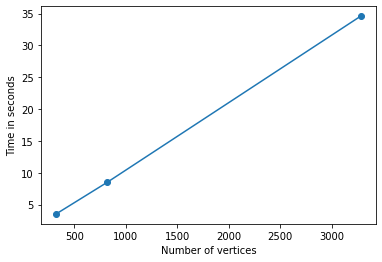

In [10]:
# Lorena dataset
# Random Initial population 

vertices_time = []

for f in os.listdir('Lorena dataset'):
  num_vertices, p, cost_matrix = read_Lorena_input_file(os.path.join('Lorena dataset', f))
  genetic = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=False, apply_hypermutation=False)
  genetic.optimize()
  vertices_time.append((num_vertices, genetic.time))

display.clear_output(wait=True)

vertices_time_sorted = sorted(vertices_time, key = lambda x: x[0])

plt.plot([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.scatter([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.ylabel('Time in seconds')
plt.xlabel('Number of vertices')
plt.show()


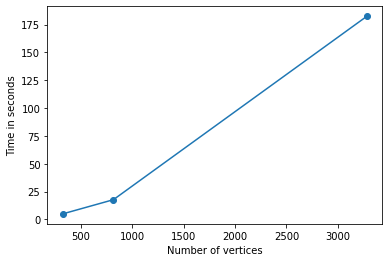

In [ ]:
# Lorena dataset
# Initial population with determining the center point of cluster

vertices_time = []

for f in os.listdir('Lorena dataset'):
  num_vertices, p, cost_matrix = read_Lorena_input_file(os.path.join('Lorena dataset', f))
  genetic = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=True, apply_hypermutation=False)
  genetic.optimize()
  vertices_time.append((num_vertices, genetic.time))

display.clear_output(wait=True)

vertices_time_sorted = sorted(vertices_time, key = lambda x: x[0])

plt.plot([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.scatter([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.ylabel('Time in seconds')
plt.xlabel('Number of vertices')
plt.show()


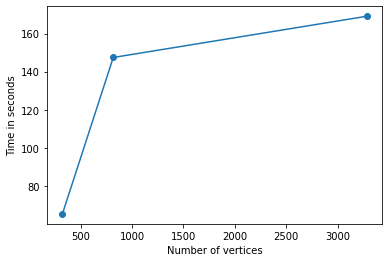

In [ ]:
# Lorena dataset
# Hypermutation + Initial population with determining the center point of cluster

vertices_time = []

for f in os.listdir('Lorena dataset'):
  num_vertices, p, cost_matrix = read_Lorena_input_file(os.path.join('Lorena dataset', f))
  genetic = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=True, apply_hypermutation=True)
  genetic.optimize()
  vertices_time.append((num_vertices, genetic.time))

display.clear_output(wait=True)

vertices_time_sorted = sorted(vertices_time, key = lambda x: x[0])

plt.plot([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.scatter([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.ylabel('Time in seconds')
plt.xlabel('Number of vertices')
plt.show()


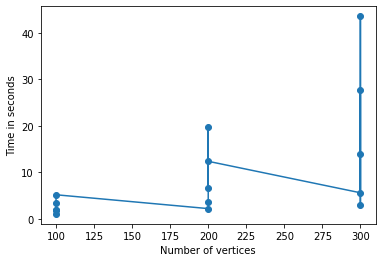

In [15]:
# OR-Library dataset
# Random Initial population 

vertices_time = []

for f in os.listdir('OR-Library'):
  num_vertices, p, cost_matrix = read_ORLibrary_input_file(os.path.join('OR-Library', f))
  genetic = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=False, apply_hypermutation=False)
  genetic.optimize()
  vertices_time.append((num_vertices, genetic.time))

display.clear_output(wait=True)

vertices_time_sorted = sorted(vertices_time, key = lambda x: x[0])

plt.plot([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.scatter([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.ylabel('Time in seconds')
plt.xlabel('Number of vertices')
plt.show()


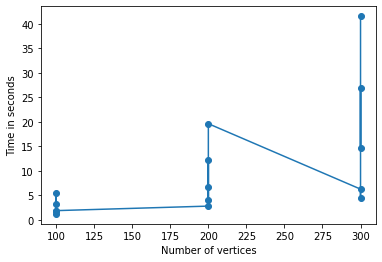

In [ ]:
# OR-Library dataset
# Initial population with determining the center point of cluster

vertices_time = []

for f in os.listdir('OR-Library'):
  num_vertices, p, cost_matrix = read_ORLibrary_input_file(os.path.join('OR-Library', f))
  genetic = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=True, apply_hypermutation=False)
  genetic.optimize()
  vertices_time.append((num_vertices, genetic.time))

display.clear_output(wait=True)

vertices_time_sorted = sorted(vertices_time, key = lambda x: x[0])

plt.plot([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.scatter([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.ylabel('Time in seconds')
plt.xlabel('Number of vertices')
plt.show()


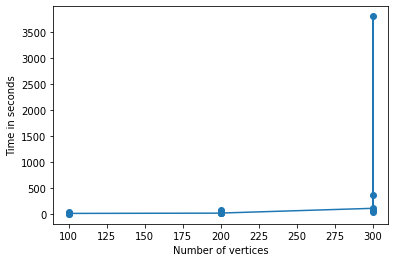

In [ ]:
# OR-Library dataset
# Hypermutation + Initial population with determining the center point of cluster

vertices_time = []

for f in os.listdir('OR-Library'):
  print(f)
  num_vertices, p, cost_matrix = read_ORLibrary_input_file(os.path.join('OR-Library', f))
  genetic = GeneticAlgorithm(num_vertices, p, cost_matrix, init_population_with_center_point=True, apply_hypermutation=True)
  genetic.optimize()
  vertices_time.append((num_vertices, genetic.time))

display.clear_output(wait=True)

vertices_time_sorted = sorted(vertices_time, key = lambda x: x[0])

plt.plot([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.scatter([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.ylabel('Time in seconds')
plt.xlabel('Number of vertices')
plt.show()
